# mm-tokenize-batcher benchmark

Benchmarks for different multimodal batching strategies — SimpleBatcher, SortedBatcher, and ClusteredBatcher — evaluated on synthetic variable-resolution image data.

In [ ]:
import numpy as np
import time
import random
from PIL import Image
from typing import List, Dict, Tuple

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Batchers

In [ ]:
from mm_tokenize_batcher import SimpleBatcher, SortedBatcher, ClusteredBatcher

Generate fake images

In [ ]:
def generate_random_image_size(min_size=224, max_size=1024):
    # Choose random aspect ratio
    H = np.random.randint(min_size, max_size + 1)
    W = np.random.randint(min_size, max_size + 1)
    return H, W

def create_fake_dataset(num_samples=1000):
    dataset = []
    for _ in range(num_samples):
        H, W = generate_random_image_size()
        fake_img = np.random.randint(0, 256, size=(H, W, 3), dtype=np.uint8)
        fake_img = Image.fromarray(fake_img)
        dataset.append({"image": fake_img})
    return dataset

Benchmark different batching strategies

In [ ]:
def compute_batch_metrics(batch):
    images = batch["images"]
    resize_h, resize_w = batch["resize_size"]
    resize_area = resize_h * resize_w

    orig_areas = np.array([img.width * img.height for img in images])
    ars = np.array([img.width / img.height for img in images])

    padded_area_ratio = (
        len(images) * resize_area / orig_areas.sum()
    )

    resize_waste = resize_area / orig_areas

    return {
        "padded_area_ratio": padded_area_ratio,
        "p95_resize_waste": np.percentile(resize_waste, 95),
        "ar_variance": ars.var(),
    }

def benchmark_batching_with_metrics(batcher, buffer):
    start = time.time()
    batches = batcher(buffer)
    elapsed = time.time() - start

    batch_metrics = [compute_batch_metrics(b) for b in batches]

    return {
        "time": elapsed,
        "num_batches": len(batches),
        "num_samples": len(buffer),
        "padded_area_ratio": np.mean([m["padded_area_ratio"] for m in batch_metrics]),
        "p95_resize_waste": np.mean([m["p95_resize_waste"] for m in batch_metrics]),
        "ar_variance": np.mean([m["ar_variance"] for m in batch_metrics]),
    }

def run_full_pass(batcher, dataset, buffer_size):
    totals = {
        "time": 0.0,
        "num_batches": 0,
        "num_samples": 0,
        "padded_area_ratio": [],
        "p95_resize_waste": [],
        "ar_variance": [],
    }

    for i in range(0, len(dataset), buffer_size):
        buffer = dataset[i:i + buffer_size]
        metrics = benchmark_batching_with_metrics(batcher, buffer)

        totals["time"] += metrics["time"]
        totals["num_batches"] += metrics["num_batches"]
        totals["num_samples"] += metrics["num_samples"]
        totals["padded_area_ratio"].append(metrics["padded_area_ratio"])
        totals["p95_resize_waste"].append(metrics["p95_resize_waste"])
        totals["ar_variance"].append(metrics["ar_variance"])

    return {
        "time_per_sample": totals["time"] / totals["num_samples"],
        "time_per_batch": totals["time"] / totals["num_batches"],
        "padded_area_ratio": np.mean(totals["padded_area_ratio"]),
        "p95_resize_waste": np.mean(totals["p95_resize_waste"]),
        "ar_variance": np.mean(totals["ar_variance"]),
    }

In [ ]:
from collections import defaultdict

num_samples = 5000
batch_size = 32
dataset = create_fake_dataset(num_samples)

buffer_sizes = []
bs = batch_size
while bs <= num_samples:
    buffer_sizes.append(bs)
    bs *= 2
if buffer_sizes[-1] != num_samples:
    buffer_sizes.append(num_samples)

results = defaultdict(dict)

In [ ]:
simple_batcher = SimpleBatcher(batch_size)

simple_stats = run_full_pass(
    simple_batcher,
    dataset,
    buffer_size=batch_size,
)

results["simple"]["buffer_size"] = batch_size
results["simple"].update(simple_stats)

print("\n=== Simple Batching (baseline) ===")
for k, v in simple_stats.items():
    print(f"{k:>20}: {v:.6f}")


=== Simple Batching (baseline) ===
     time_per_sample: 0.000005
      time_per_batch: 0.000172
   padded_area_ratio: 1.001732
    p95_resize_waste: 3.125467
         ar_variance: 0.546298


In [ ]:
for mode in ["sorted-ratio", "sorted-area", "sorted-lex", "clustered"]:
    print(f"\n=== {mode.upper()} BATCHING ===")
    for buffer_size in buffer_sizes:
        if mode == "sorted-area":
            batcher = SortedBatcher(batch_size, key_fn='area')
        elif mode == "sorted-ratio":
            batcher = SortedBatcher(batch_size)
        elif mode == "sorted-lex":
            batcher = SortedBatcher(batch_size, key_fn=lambda x: (x[1] / x[2], x[1] * x[2]))
        else:
            batcher = ClusteredBatcher(batch_size)

        stats = run_full_pass(
            batcher,
            dataset,
            buffer_size=buffer_size,
        )

        results[mode][buffer_size] = stats

        print(
            f"buffer={buffer_size:5d} | "
            f"time/sample={stats['time_per_sample']:.6e} | "
            f"time/batch={stats['time_per_batch']:.6e} | "
            f"resize_waste={stats['padded_area_ratio']:.3f} | "
            f"p95_resize_waste={stats['p95_resize_waste']:.3f} |"
            f"ar_var={stats['ar_variance']:.4f}"
        )


=== SORTED-RATIO BATCHING ===
buffer=   32 | time/sample=3.074121e-06 | time/batch=9.790196e-05 | resize_waste=1.002 | p95_resize_waste=3.125 |ar_var=0.5463
buffer=   64 | time/sample=2.191830e-06 | time/batch=6.980349e-05 | resize_waste=0.956 | p95_resize_waste=2.973 |ar_var=0.2615
buffer=  128 | time/sample=2.200031e-06 | time/batch=7.006469e-05 | resize_waste=0.949 | p95_resize_waste=2.979 |ar_var=0.1118
buffer=  256 | time/sample=1.980257e-06 | time/batch=6.306551e-05 | resize_waste=0.946 | p95_resize_waste=3.002 |ar_var=0.0437
buffer=  512 | time/sample=2.052069e-06 | time/batch=6.535251e-05 | resize_waste=0.945 | p95_resize_waste=3.027 |ar_var=0.0157
buffer= 1024 | time/sample=2.258158e-06 | time/batch=7.191585e-05 | resize_waste=0.945 | p95_resize_waste=3.015 |ar_var=0.0056
buffer= 2048 | time/sample=2.130604e-06 | time/batch=6.785362e-05 | resize_waste=0.945 | p95_resize_waste=3.016 |ar_var=0.0036
buffer= 4096 | time/sample=2.250528e-06 | time/batch=7.167288e-05 | resize_waste

Plotting

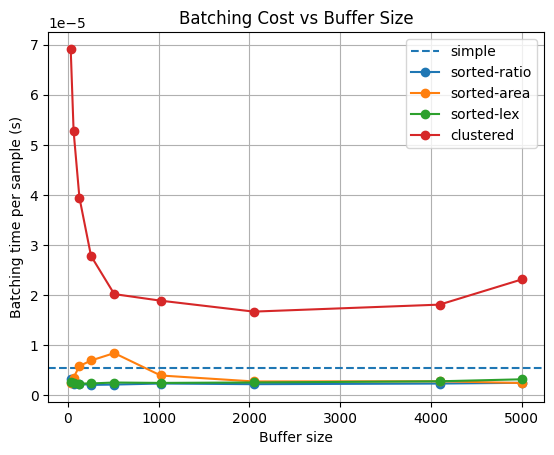

In [ ]:
# Time Tradeoffs
import matplotlib.pyplot as plt

plt.figure()
plt.axhline(
    results["simple"]["time_per_sample"],
    linestyle="--",
    label="simple",
)

for mode in ["sorted-ratio", "sorted-area", "sorted-lex", "clustered"]:
    xs = list(results[mode].keys())
    ys = [results[mode][b]["time_per_sample"] for b in xs]
    plt.plot(xs, ys, marker="o", label=mode)

plt.xlabel("Buffer size")
plt.ylabel("Batching time per sample (s)")
plt.title("Batching Cost vs Buffer Size")
plt.legend()
plt.grid(True)
plt.show()

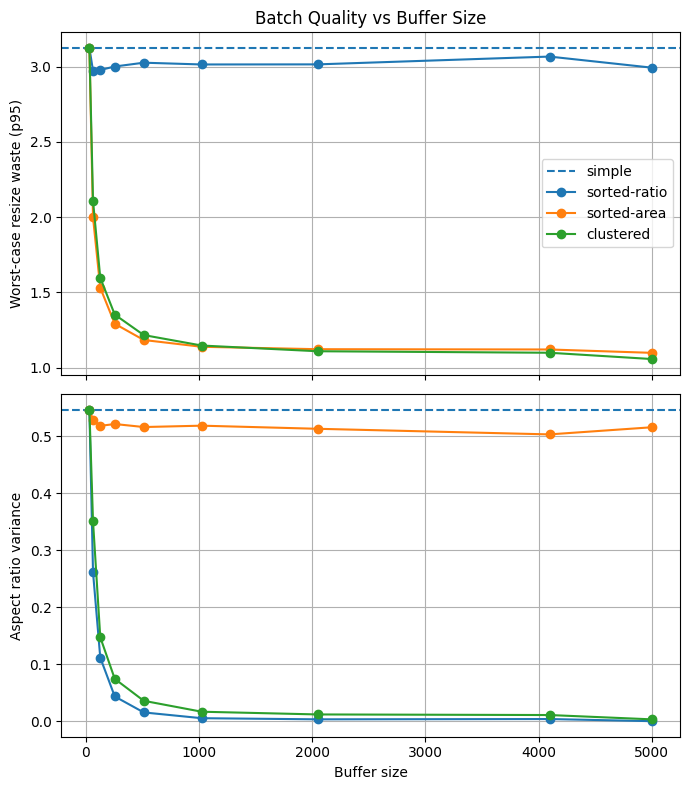

In [ ]:
# Buffer size vs mean resize wast
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 8))

ax2.axhline(
    results["simple"]["ar_variance"],
    linestyle="--",
    label="simple",
)

for mode in ["sorted-ratio", "sorted-area", "clustered"]:
    xs = list(results[mode].keys())
    ys = [results[mode][b]["ar_variance"] for b in xs]
    ax2.plot(xs, ys, marker="o", label=mode)

ax2.set_xlabel("Buffer size")
ax2.set_ylabel("Aspect ratio variance")
ax2.grid(True)

ax1.axhline(
    results["simple"]["p95_resize_waste"],
    linestyle="--",
    label="simple",
)

for mode in ["sorted-ratio", "sorted-area", "clustered"]:
    xs = list(results[mode].keys())
    ys = [results[mode][b]["p95_resize_waste"] for b in xs]
    ax1.plot(xs, ys, marker="o", label=mode)

ax1.set_ylabel("Worst-case resize waste (p95)")
ax1.set_title("Batch Quality vs Buffer Size")
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()